In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sys import path
path.append("../utils/")

from utils import get_datasets

In [4]:
DATASETS = ["webkb"]

In [6]:
df = get_datasets(DATASETS, path="/home/welton/data/pd_datasets/__dset__.csv", sep=';')["webkb"]

In [10]:
counts = df.label.value_counts()

In [12]:
keys, values = counts.keys(), counts.values

Text(0.5, 1.0, 'WEBKB')

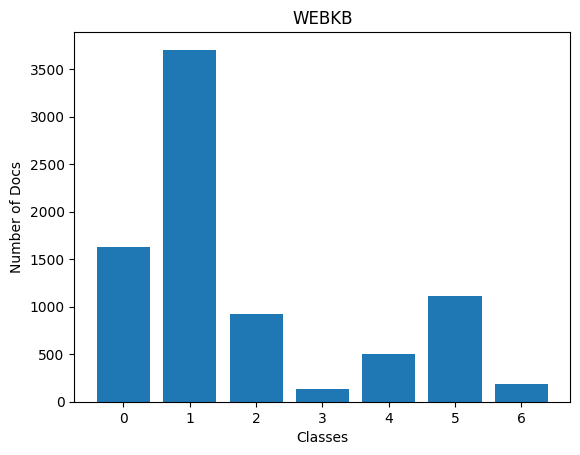

In [26]:
x = np.arange(values.shape[0])
plt.bar(x, values[keys.argsort()])
_ = plt.xticks(ticks=x, labels=x)
plt.ylabel("Number of Docs")
plt.xlabel("Classes")
plt.title("WEBKB")

In [20]:
values[keys.argsort()]

array([1630, 3705,  926,  137,  501, 1118,  182])

In [23]:
keys

Int64Index([1, 0, 5, 2, 4, 6, 3], dtype='int64')

In [29]:
labels = df.label

In [35]:
clfs_preds = df.drop(columns=['label', 'fold_id', 'docs', 'conc_size', 'hit_counts', 'conc_pred', 'xlnet', 'bert'])
clfs_preds.columns

Index(['spr', 'kpr', 'xtr', 'xfr', 'stmk', 'ltmk', 'lpr', 'str', 'ltr', 'lfr',
       'kfr', 'ktmk', 'rep_bert', 'ktr', 'sfr', 'xtmk', 'xlnet_softmax',
       'xpr'],
      dtype='object')

In [111]:
def micro(labels, preds, target_class=1):

    preds = preds
    # Computing recall.
    class_docs = labels == target_class
    y_hat = preds[class_docs]
    retrived = np.sum(y_hat == target_class)
    divisor = np.sum(class_docs)
    rec = retrived / divisor if retrived > 0 and divisor > 0 else 0
    # Computing precision.
    y_hat = preds == target_class
    equal = labels[y_hat]
    hits = np.sum(equal == target_class)
    divisor = np.sum(y_hat)
    prec = hits / divisor if hits > 0 and divisor > 0 else 0
    m = 2 * rec * prec / (prec + rec) if prec + rec > 0 else 0
    return prec, rec, m


In [115]:
means = []
for target_class in np.arange(len(np.unique(labels))):
    clfs = {}
    dict_class = {}
    for fold in np.arange(10):
        fold = df.fold_id == fold
        sub_preds = clfs_preds[fold]
        sub_labels = labels[fold]
        for col in clfs_preds.columns:
            prec, rec, m = micro(sub_labels, sub_preds[col].values, target_class=target_class)
            if col not in clfs:
                clfs[col] = [[prec, rec, m]]
            clfs[col].append([prec, rec, m])

    for key in clfs:
        clfs[key] = np.mean(clfs[key], axis=0)

    scores = pd.DataFrame(np.vstack(list(clfs.values()))*100, columns=["Prec", "Rec", "Micro"])
    #scores["CLFs"] = list(clfs.keys())
    #np.mean(scores.drop(columns=["CLFs"]).values, axis=0)
    means.append(np.mean(scores.values, axis=0))

In [123]:
s = pd.DataFrame(np.vstack(means), columns=["Prec", "Rec", "Micro"])
s["Class"] = np.arange(len(means))
s

,Prec,Rec,Micro,Class
0,76.816153,77.808762,77.114438,0
1,79.515544,83.959770,81.534429,1
2,81.525070,79.155569,80.112722,2
3,52.435602,19.419469,25.920349,3
4,68.035228,47.829867,54.300850,4
5,79.360458,79.647342,79.387679,5
6,79.702468,77.119145,77.284056,6
